In [7]:
import os.path

from model import get_models_and_path, get_remote_vggs_and_path, get_resnets_and_path, get_remote_resnets_and_path
import torch
import pandas as pd
from plot_and_print import plot_tile
import os
from PIL import Image
import matplotlib.pyplot as plt
from zennit.attribution import Gradient
from relevance import plot_relevance
from data_loader import TileLoader
from scipy import stats

from zennit import torchvision, composites, image
import numpy as np
import zennit as zen
can_res = zen.torchvision.ResNetCanonizer()


In [19]:
data_dir = "../results/"
patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients.remove('p021')
filenames = []
for patient in patients:
    filenames.append(data_dir + patient + "/RUBCNL_results_new.csv")

patient_id = 2
print(filenames[patient_id])
df = pd.read_csv(filenames[patient_id])
def cut_path(x):
    return x[3:]
new_col = df.path
new_col = new_col.apply(cut_path)
df.path = new_col


loader = TileLoader()

# best values first in list, ascending
def get_sorted_values_by_col(df, min, max, colname='../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt', gene="RUBCNL"):
    idx = df[gene].sort_values()[min:max].index.values

    vals_orig_by_range = df.iloc[idx]
    diff = vals_orig_by_range[gene] - vals_orig_by_range[colname]

    diff = diff.abs().sort_values()
    return df.iloc[diff.index]
small_vals  = get_sorted_values_by_col(df, 0, 100)
middle_vals = get_sorted_values_by_col(df, int(len(df)/2-50), int(len(df)/2+50))
big_vals    = get_sorted_values_by_col(df, -100, len(df))

../results/p026/RUBCNL_results_new.csv


In [20]:
df.head()

,tile,RUBCNL,x,y,path,../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../remote_models/new/models/vgg13/base_model/VGG13_ep_29.pt,../remote_models/new/models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../remote_models/new/models/vgg13/random_weights/VGG13_ep_29.pt
0,p026_0_0.tiff,0.003145,78,78,../Test_Data/p026/Tiles_156/p026_0_0.tiff,0.040149,0.813379,0.442170,-0.261281,0.439540,0.411270,0.237734,0.126129,0.472025,0.569215,0.037021,0.053088,-0.003972
1,p026_1_0.tiff,-0.899233,234,78,../Test_Data/p026/Tiles_156/p026_1_0.tiff,0.056609,-1.046845,-0.313334,-0.184967,0.232738,0.233955,0.071939,-0.284216,-0.724437,0.415052,0.030182,-0.130391,0.004319
2,p026_2_0.tiff,-0.899233,390,78,../Test_Data/p026/Tiles_156/p026_2_0.tiff,0.064394,-0.458315,-0.097621,0.041478,-0.350232,-0.036998,0.280480,-0.260060,-0.456181,-0.298748,0.036595,-0.227085,-0.011240
3,p026_3_0.tiff,1.161357,546,78,../Test_Data/p026/Tiles_156/p026_3_0.tiff,0.030245,0.576062,0.498631,-0.281469,0.499625,1.154395,0.331976,0.167997,0.196532,0.595813,0.032346,0.094009,0.009301
4,p026_4_0.tiff,-0.899233,702,78,../Test_Data/p026/Tiles_156/p026_4_0.tiff,0.058192,1.437813,0.317691,0.006563,-0.310576,-0.487692,0.587733,-0.074060,0.019463,-0.462593,0.038148,-0.015698,0.011269


In [12]:
def plot_model_comparison(grads_res, grads_vgg, image_path, width=4, subplot_size=40):
    plt.figure(figsize=(100,100))
    height = int((len(grads_res) + len(grads_vgg) + 1) / width + 0.999)
    f, ax = plt.subplots(height,width)
    f.set_figheight(subplot_size)
    f.set_figwidth(subplot_size)
    for i in range(len(grads_res)):
        ax[int(i/width),i%width].imshow(grads_res[i][0])
        ax[int(i/width),i%width].set_title(grads_res[i][1]+"\nlabel: "+str(round(grads_res[i][2], 3))+"\npred: "+str(round(grads_res[i][3], 3)))

    for i in range(len(grads_res), len(grads_vgg) + len(grads_res)):
        j = i - len(grads_res)
        ax[int(i/width),i%width].imshow(grads_vgg[j][0])
        ax[int(i/width),i%width].set_title(grads_vgg[j][1]+"\nlabel: "+str(round(grads_vgg[j][2], 3))+"\npred: "+str(round(grads_vgg[j][3], 3)))
    img = Image.open(image_path)
    ax[-1,-1].imshow(img)
    ax[-1,-1].set_title('original')
    plt.show()

def get_grads(models, composite, idx, df, loader, gene="RUBCNL"):
    imgs = []
    for model,path in models:

        model.eval()
        img = loader.open(df.path[idx]).unsqueeze(0)
        with Gradient(model, composite) as attributor:
            out, grad = attributor(img)
        rel = plot_relevance(grad, filename=None, only_return=True)
        position = path.find('models') + len('models')
        imgs.append((rel,path[position:], df.iloc[idx][gene], out.item()))
    return imgs



In [5]:
can_vgg = zen.torchvision.VGGCanonizer()
"""
transform_norm = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))
composite_vgg = zen.composites.EpsilonGammaBox(low=low, high=high, canonizers=[can_vgg])
"""
can_res = zen.torchvision.ResNetCanonizer()

composite_res = zen.composites.EpsilonPlusFlat(canonizers=[can_res])
composite_vgg = zen.composites.EpsilonPlusFlat(canonizers=[can_vgg])

In [9]:
#models = get_models_and_path()
resnets = get_remote_resnets_and_path()
vggs = get_remote_vggs_and_path()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [10]:
tile_id = 4170
tile_path = df.iloc[tile_id].path

<Figure size 10000x10000 with 0 Axes>

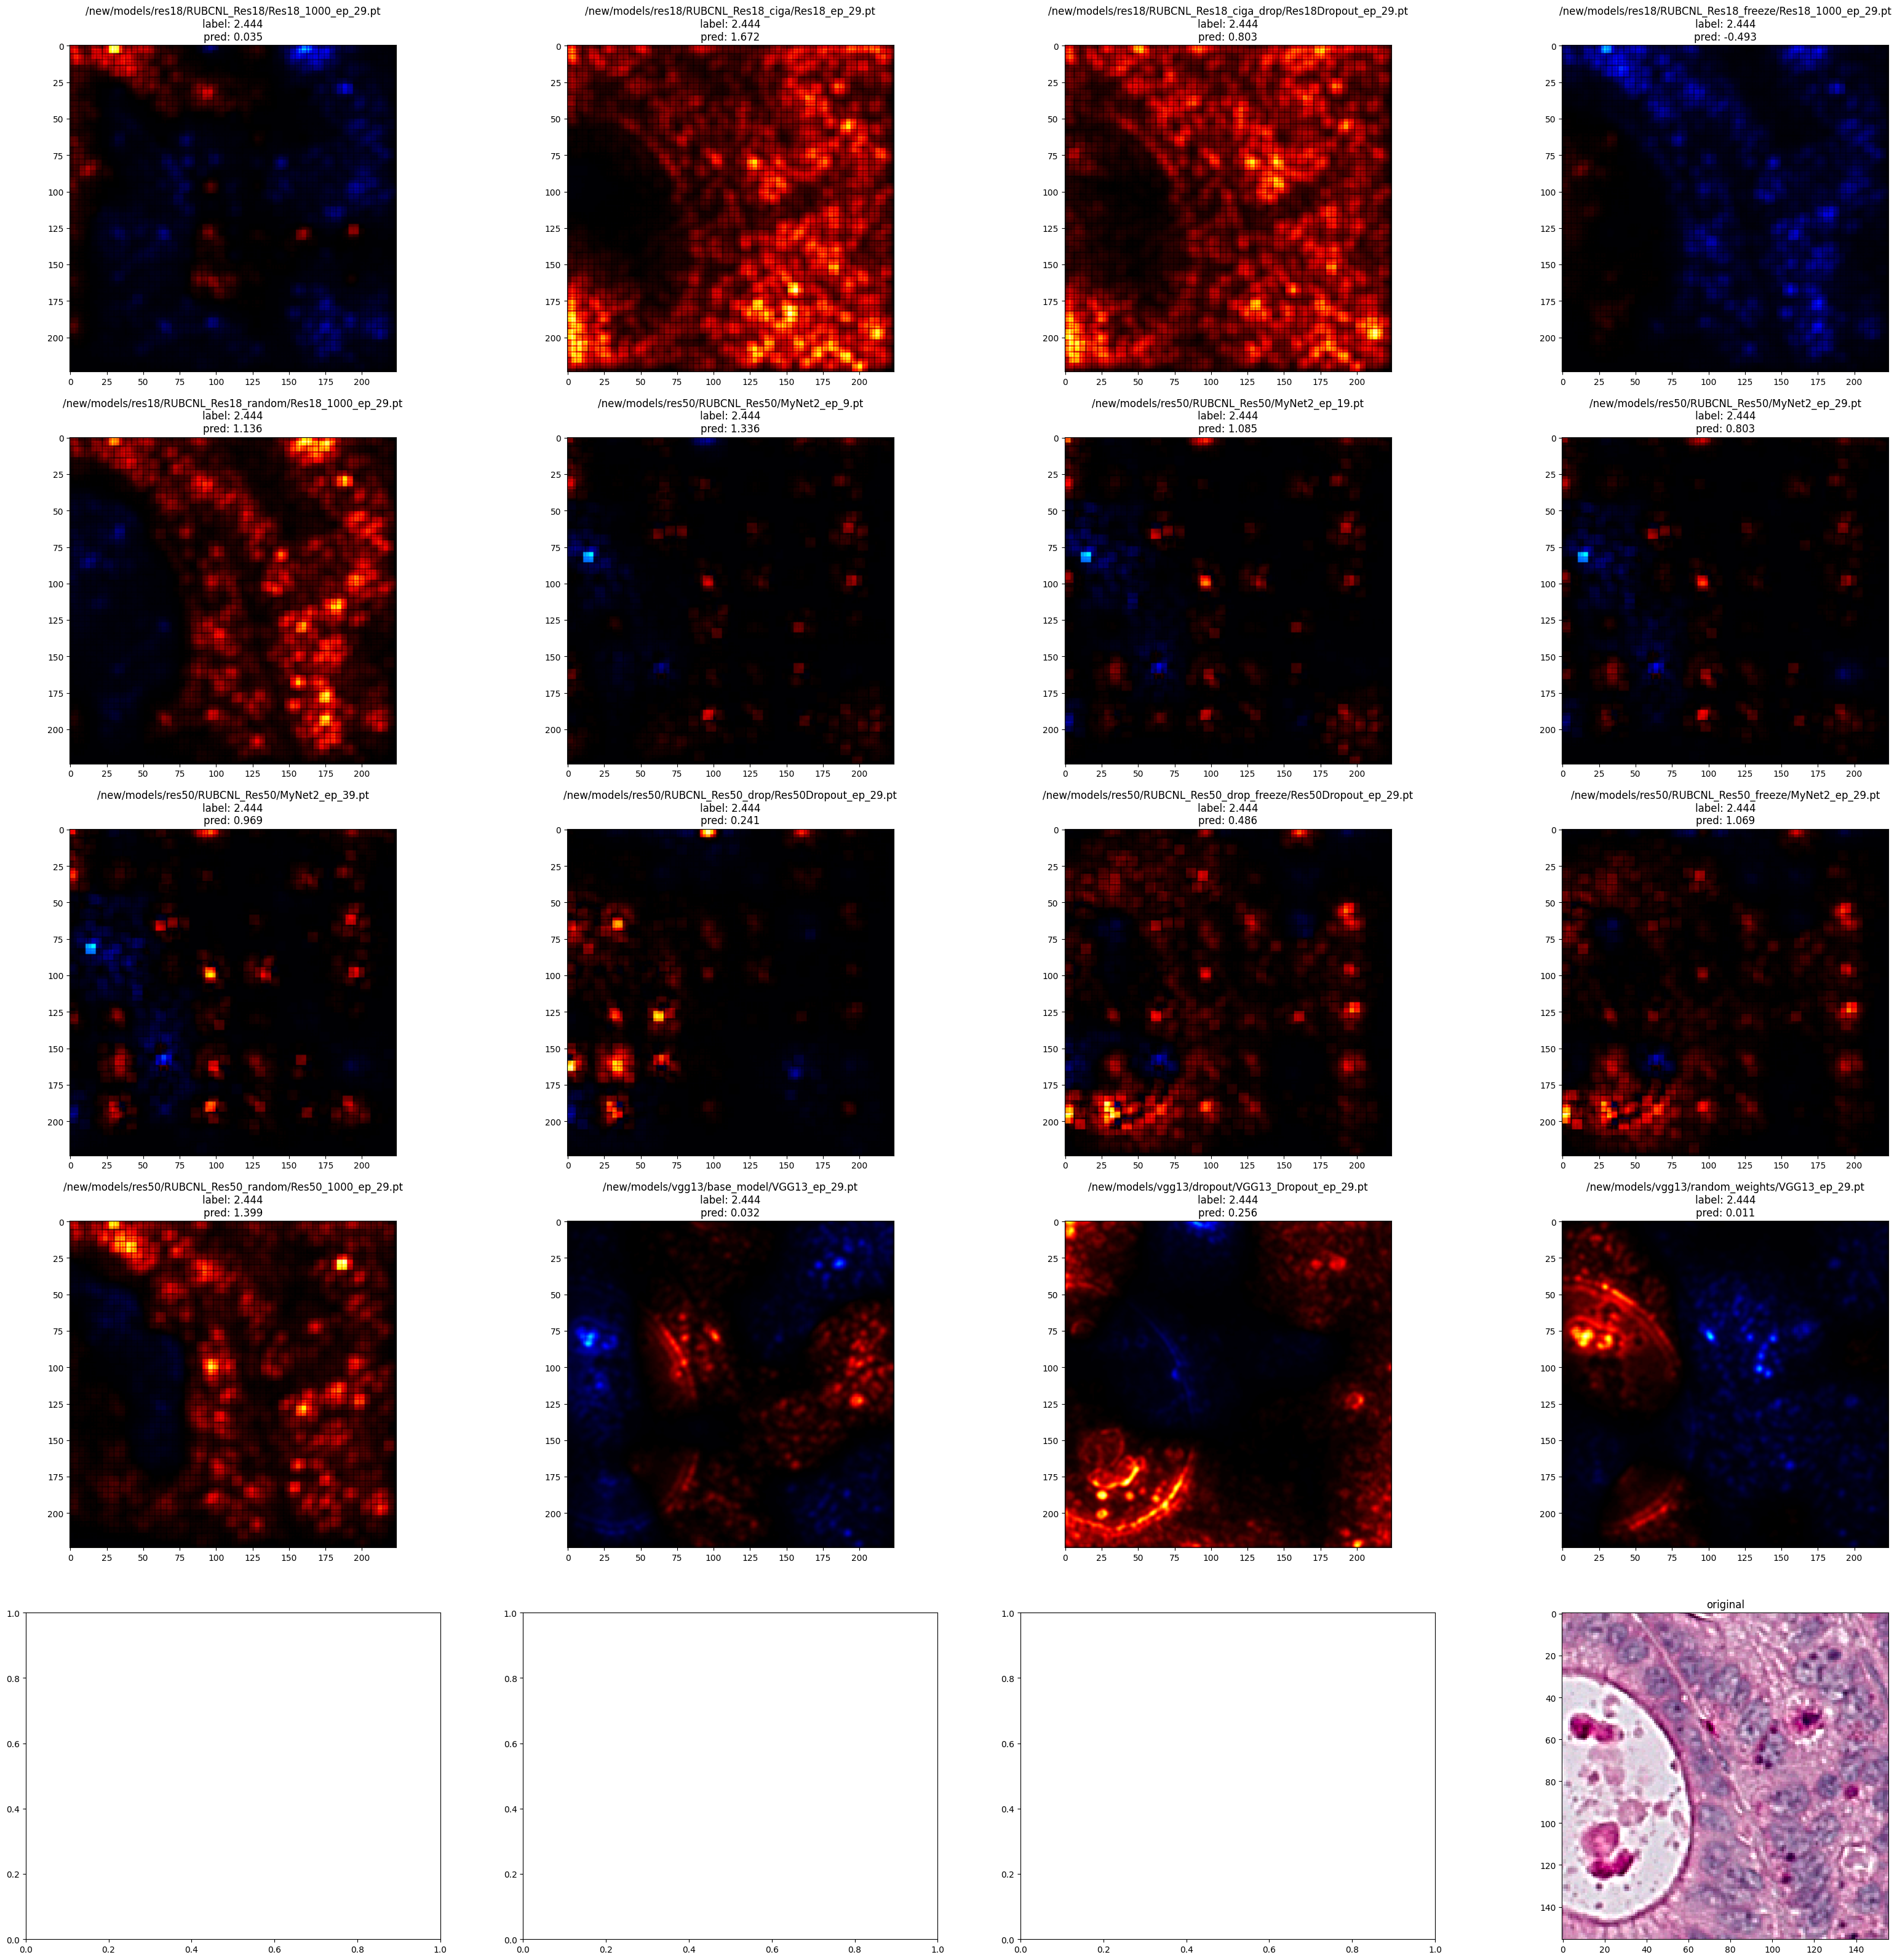

In [13]:
grads_res = get_grads(resnets, composite_res, 4170, df, loader)
grads_vgg = get_grads(vggs, composite_vgg, 4170, df, loader)
plot_model_comparison(grads_res, grads_vgg, tile_path)

In [14]:
best = [small_vals[0:5], middle_vals[0:5], big_vals[0:5]]
worst = [small_vals[-5:], middle_vals[-5:], big_vals[-5:]]
# interesting:
interesting = []
interesting.append(best[0].index.values[1])
#set = worst[2]
#id = set.index.values[1]


set = best[2]
id = set.index.values[3]
row = df.iloc[id]
print(id)
grads_res = get_grads(resnets, composite_res, id, df, loader)
#plot_model_comparison(grads_res, [], row.path)

4170


In [ ]:
grads_vgg = get_grads(vggs, composite_vgg, id, df, loader)
plot_model_comparison([], grads_vgg, row.path)


In [22]:
# pearson
target = df["RUBCNL"]
preds = df.iloc[:, 5:]
print(preds.columns)

Index(['../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt',
       '../remote_models/new/models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt',
       '../remote_models/new/models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt',
       '../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt',
       '../remote_models/new/models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt',
       '../remote_models/new/models/res50/RUBCNL_Res50/MyNet2_ep_29.pt',
       '../remote_models/new/models/res50/RUBCNL_Res50_drop/Res50Dropout_ep_29.pt',
       '../remote_models/new/models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt',
       '../remote_models/new/models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt',
       '../remote_models/new/models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt',
       '../remote_models/new/models/vgg13/base_model/VGG13_ep_29.pt',
       '../remote_models/new/models/vgg13/dropout/VGG13_Dropout_ep_29.pt',
       '../remote_models/new/mod

In [23]:
pearsons = pd.DataFrame(columns=preds.columns)
print(patients)
for i in range(len(filenames)):
    df_tmp = pd.read_csv(filenames[i])
    target = df_tmp["RUBCNL"]
    preds = df_tmp.iloc[:, 5:]
    row = []
    for name, data in preds.items():
        pearsons.at[i,name] = round(stats.pearsonr(target, data)[0],3)
    print(pearsons.shape)
#print(pearsons.head())
print(pearsons.shape)
pearsons['idx'] = patients
pearsons.set_index('idx', append=True)
pearsons.head()
    

['p020', 'p016', 'p026', 'p014', 'p013', 'p025', 'p007', 'p009', 'p008']
(1, 13)
(2, 13)
(3, 13)
(4, 13)
(5, 13)
(6, 13)
(7, 13)
(8, 13)
(9, 13)
(9, 13)


,../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../remote_models/new/models/vgg13/base_model/VGG13_ep_29.pt,../remote_models/new/models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../remote_models/new/models/vgg13/random_weights/VGG13_ep_29.pt,idx
0,0.98,0.934,0.822,-0.717,0.734,0.995,0.258,0.627,0.723,0.802,-0.215,0.514,0.153,p020
1,0.987,0.962,0.907,-0.858,0.872,0.996,0.299,0.775,0.819,0.902,-0.11,0.555,0.138,p016
2,-0.43,0.569,0.582,-0.648,0.631,0.619,0.195,0.608,0.588,0.603,-0.114,0.521,0.141,p026
3,0.981,0.948,0.843,-0.694,0.757,0.995,-0.07,0.604,0.699,0.834,-0.054,0.378,0.189,p014
4,0.603,0.618,0.611,-0.606,0.618,0.642,0.374,0.546,0.532,0.601,-0.135,0.463,-0.088,p013


In [24]:
pearsons[pearsons["idx"]=='p009']

,../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt,../remote_models/new/models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_freeze/MyNet2_ep_29.pt,../remote_models/new/models/res50/RUBCNL_Res50_random/Res50_1000_ep_29.pt,../remote_models/new/models/vgg13/base_model/VGG13_ep_29.pt,../remote_models/new/models/vgg13/dropout/VGG13_Dropout_ep_29.pt,../remote_models/new/models/vgg13/random_weights/VGG13_ep_29.pt,idx
7,0.529,0.527,0.523,-0.506,0.492,0.54,0.088,0.474,0.481,0.472,-0.003,0.391,0.11,p009
